## 1. Import Required Libraries

In [16]:
# Install required packages (run only once)
!{sys.executable} -m pip install -q scipy seaborn matplotlib pymysql sqlalchemy

In [17]:
# Data processing
import pandas as pd
import numpy as np

# Statistical tests
from scipy.stats import pearsonr, f_oneway

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import utility functions from db_utils
from notebooks.utils.db_utils import read_from_db, setup_display_settings, setup_visualization_settings

# Settings for better display
setup_display_settings(float_format='{:.2f}', precision=2)
setup_visualization_settings()

print("All libraries imported successfully")

Display settings configured
Visualization settings configured
All libraries imported successfully


## 2. Load Data

In [18]:
# Load data DIRECTLY from MySQL database
df = read_from_db("SELECT * FROM hiking_routes")

print(f"Dataset loaded from database: {df.shape[0]} hiking trails, {df.shape[1]} variables")

Loaded 375 rows, 13 columns from database
Dataset loaded from database: 375 hiking trails, 13 variables


---
# Test 1: Correlation Analysis

**Goal:** Investigate the linear relationship between numerical variables

**Hypotheses:**
- H₀ (Null hypothesis): There is no relationship between the variables (correlation = 0)
- H₁ (Alternative hypothesis): There is a relationship between the variables (correlation ≠ 0)

**Interpretation of p-value:**
- p < 0.05: The relationship is statistically significant
- p ≥ 0.05: No significant relationship detectable

## 1.1 Select Numerical Variables

In [19]:
# Select relevant numerical columns for correlation analysis
numerical_cols = ['distance_km', 'duration_min', 'ascent_m', 'descent_m', 'latitude', 'longitude']

# Check which columns are actually available
available_cols = [col for col in numerical_cols if col in df.columns]

print(f"Available numerical variables: {available_cols}")
print(f"\nCount: {len(available_cols)} variables")

Available numerical variables: ['distance_km', 'duration_min', 'ascent_m', 'descent_m', 'latitude', 'longitude']

Count: 6 variables


## 1.2 Pairplot - Visual Overview of All Relationships

Visual overview of all relationships between numerical variables:



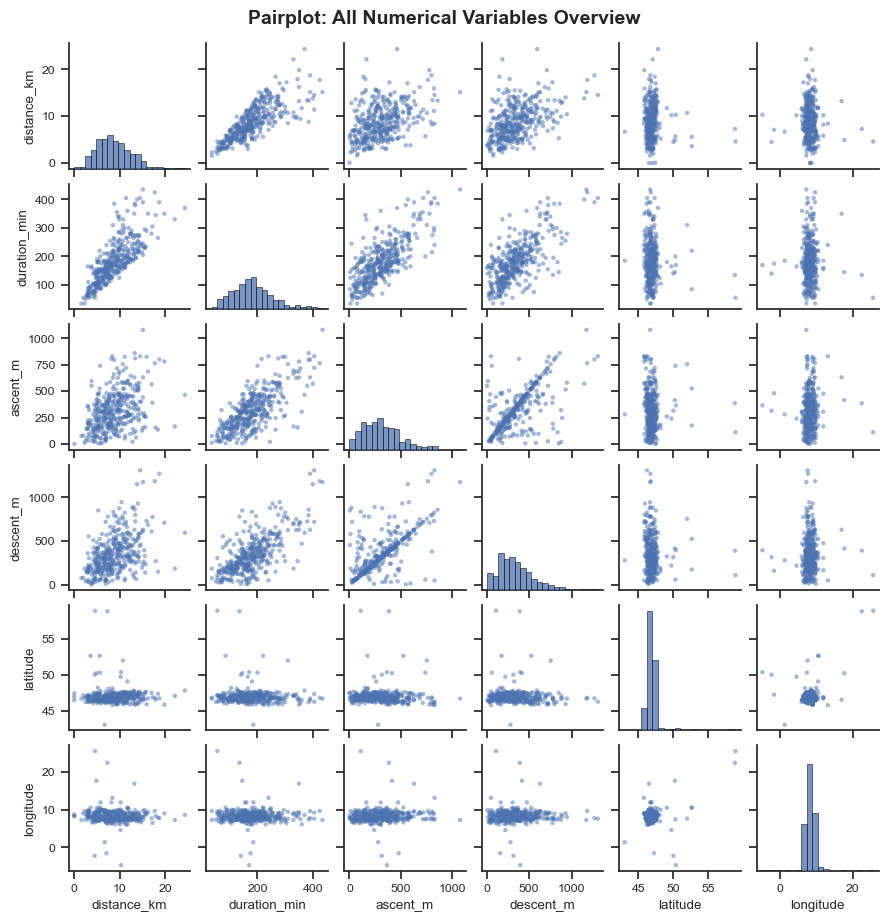


Interpretation:
- Diagonal: Histograms show the distribution of each variable
- Off-diagonal: Scatterplots show relationships between variable pairs
- Linear patterns indicate correlations


In [20]:
# Pairplot for visual overview of all relationships
print("Visual overview of all relationships between numerical variables:\n")

# Seaborn settings for pairplot
sns.set(style="ticks", font_scale=0.8)

# Create pairplot
g = sns.pairplot(df[available_cols], 
                 height=1.5, 
                 aspect=1,
                 plot_kws={'alpha':0.5, 's':10, 'edgecolor':'none'},
                 diag_kws={'bins':20, 'edgecolor':'black'})

# Add title
g.fig.suptitle('Pairplot: All Numerical Variables Overview', y=1.02, fontsize=14, fontweight='bold')

plt.show()

print("\nInterpretation:")
print("- Diagonal: Histograms show the distribution of each variable")
print("- Off-diagonal: Scatterplots show relationships between variable pairs")
print("- Linear patterns indicate correlations")

## 1.3 Pearson Correlation Matrix (with p-values)

Pearson Correlation Matrix:
              distance_km  duration_min  ascent_m  descent_m  latitude  longitude
distance_km          1.00          0.78      0.41       0.47     -0.03      -0.06
duration_min         0.78          1.00      0.74       0.70     -0.08      -0.02
ascent_m             0.41          0.74      1.00       0.64     -0.03       0.06
descent_m            0.47          0.70      0.64       1.00     -0.06       0.03
latitude            -0.03         -0.08     -0.03      -0.06      1.00       0.43
longitude           -0.06         -0.02      0.06       0.03      0.43       1.00


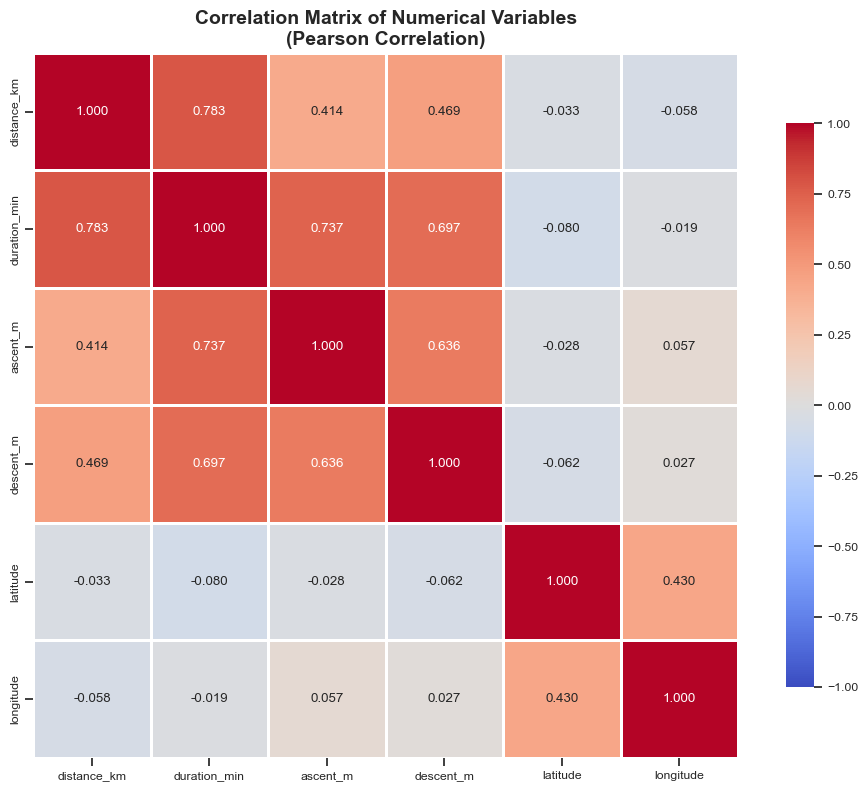

In [21]:
# Calculate Pearson correlation matrix
correlation_matrix = df[available_cols].corr(method='pearson')

print("Pearson Correlation Matrix:")
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='coolwarm', 
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Variables\n(Pearson Correlation)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.4 Detailed Correlation Analysis with p-values

p-Value Matrix (Significance of Correlations):
              distance_km  duration_min  ascent_m  descent_m  latitude  longitude
distance_km          0.00          0.00      0.00       0.00      0.55       0.29
duration_min         0.00          0.00      0.00       0.00      0.14       0.73
ascent_m             0.00          0.00      0.00       0.00      0.60       0.29
descent_m            0.00          0.00      0.00       0.00      0.25       0.62
latitude             0.55          0.14      0.60       0.25      0.00       0.00
longitude            0.29          0.73      0.29       0.62      0.00       0.00


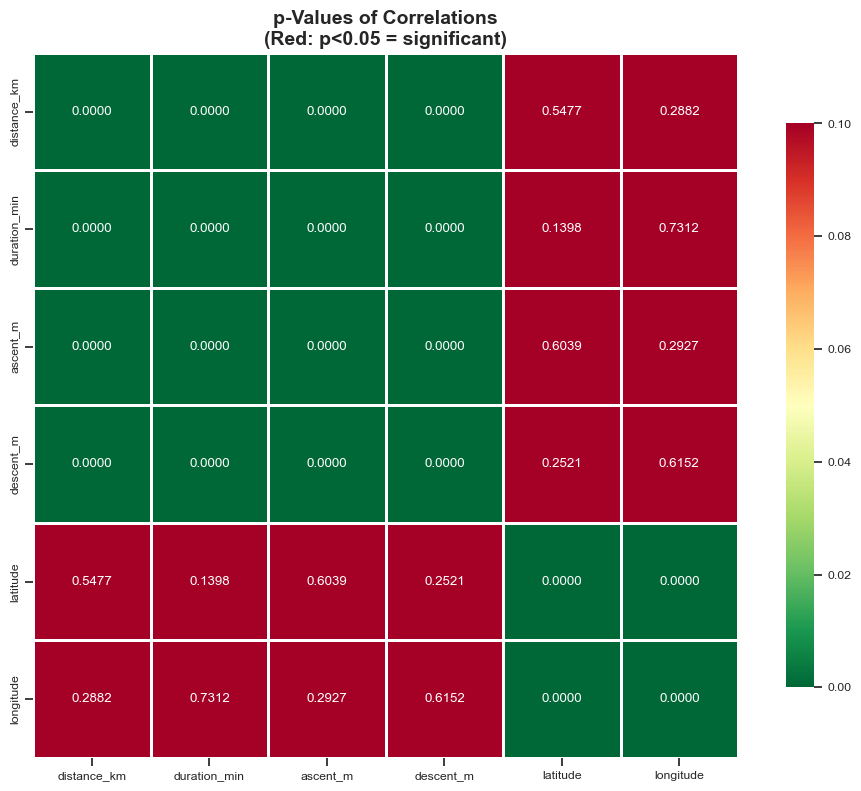


Interpretation: p < 0.05 means statistically significant correlation


In [22]:
# Function to calculate correlation and p-value for all pairs
def calculate_pvalues(df, cols):
    """
    Calculate p-values for all correlation pairs
    """
    n = len(cols)
    pval_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                pval_matrix[i, j] = 0  # Diagonal
            else:
                # Remove NaN values for each pair
                valid_data = df[[cols[i], cols[j]]].dropna()
                if len(valid_data) > 2:
                    _, p_value = pearsonr(valid_data[cols[i]], valid_data[cols[j]])
                    pval_matrix[i, j] = p_value
                else:
                    pval_matrix[i, j] = 1.0
    
    return pd.DataFrame(pval_matrix, columns=cols, index=cols)

# Calculate p-values
pvalue_matrix = calculate_pvalues(df, available_cols)

print("p-Value Matrix (Significance of Correlations):")
print(pvalue_matrix)

# Visualize p-values
plt.figure(figsize=(10, 8))
sns.heatmap(pvalue_matrix, 
            annot=True, 
            fmt='.4f', 
            cmap='RdYlGn_r',  # Red = significant, Green = not significant
            center=0.05,
            vmin=0, 
            vmax=0.1,
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('p-Values of Correlations\n(Red: p<0.05 = significant)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation: p < 0.05 means statistically significant correlation")

## 1.5 Identify Significant Correlations

In [23]:
# Create overview of significant correlations
print("="*80)
print("SIGNIFICANT CORRELATIONS (p < 0.05)")
print("="*80)

results = []
for i in range(len(available_cols)):
    for j in range(i+1, len(available_cols)):  # Only upper triangle matrix
        col1 = available_cols[i]
        col2 = available_cols[j]
        corr = correlation_matrix.loc[col1, col2]
        pval = pvalue_matrix.loc[col1, col2]
        
        if pval < 0.05:
            results.append({
                'Variable 1': col1,
                'Variable 2': col2,
                'Correlation': corr,
                'p-Value': pval,
                'Significant': 'Yes' if pval < 0.05 else 'No'
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Correlation', key=abs, ascending=False)

if len(results_df) > 0:
    print(f"\nNumber of significant correlations: {len(results_df)}\n")
    print(results_df.to_string(index=False))
else:
    print("\nNo significant correlations found.")

print("\n" + "="*80)

SIGNIFICANT CORRELATIONS (p < 0.05)

Number of significant correlations: 7

  Variable 1   Variable 2  Correlation  p-Value Significant
 distance_km duration_min         0.78     0.00         Yes
duration_min     ascent_m         0.74     0.00         Yes
duration_min    descent_m         0.70     0.00         Yes
    ascent_m    descent_m         0.64     0.00         Yes
 distance_km    descent_m         0.47     0.00         Yes
    latitude    longitude         0.43     0.00         Yes
 distance_km     ascent_m         0.41     0.00         Yes



## 1.6 Example: Detailed Analysis of a Strong Correlation

Detailed Analysis: distance_km vs. duration_min
Correlation: 0.7828
p-Value: 0.000000


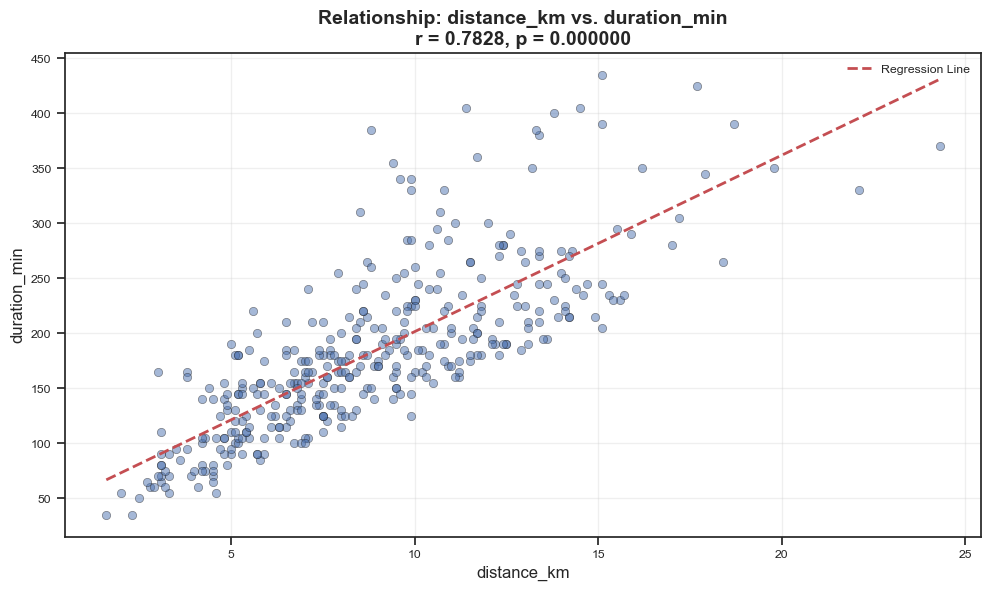

In [24]:
# Select strongest correlation for detailed analysis
if len(results_df) > 0:
    strongest = results_df.iloc[0]
    var1 = strongest['Variable 1']
    var2 = strongest['Variable 2']
    
    print(f"Detailed Analysis: {var1} vs. {var2}")
    print(f"Correlation: {strongest['Correlation']:.4f}")
    print(f"p-Value: {strongest['p-Value']:.6f}")
    
    # Filter for valid data in both columns
    valid_data = df[[var1, var2]].dropna()
    x_data = valid_data[var1]
    y_data = valid_data[var2]
    
    # Scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data, y_data, alpha=0.5, edgecolors='k', linewidth=0.5)
    
    # Regression line
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    x_sorted = np.sort(x_data)
    plt.plot(x_sorted, p(x_sorted), "r--", linewidth=2, label='Regression Line')
    
    plt.xlabel(var1, fontsize=12)
    plt.ylabel(var2, fontsize=12)
    plt.title(f'Relationship: {var1} vs. {var2}\nr = {strongest["Correlation"]:.4f}, p = {strongest["p-Value"]:.6f}', 
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No significant correlations available for detailed analysis.")

---
# Test 2: ANOVA (Analysis of Variance)

**Goal:** Test whether there are significant differences in a numerical variable between different groups

**Example:** Are there significant differences in hiking trail length between different cantons?

**Hypotheses:**
- H₀ (Null hypothesis): All groups have the same mean
- H₁ (Alternative hypothesis): At least one group has a different mean

**Interpretation of p-value:**
- p < 0.05: There are significant differences between groups
- p ≥ 0.05: No significant differences detectable

## 2.1 Prepare Data for ANOVA

In [25]:
# Check which categorical variables are available
print("Available columns in dataset:")
print(df.columns.tolist())

# Identify possible grouping variables
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical variables: {categorical_cols}")

Available columns in dataset:
['url', 'title', 'location', 'canton', 'difficulty_level', 'difficulty_num', 'duration_min', 'distance_km', 'ascent_m', 'descent_m', 'physical_demand', 'latitude', 'longitude']

Categorical variables: ['url', 'title', 'location', 'canton', 'difficulty_level', 'physical_demand']


## 2.2 Perform ANOVA Test

In [26]:
# Example: ANOVA for length by canton (or another categorical variable)
# Adjust the variable name to match your actual column names

# Try different possible column names for canton
possible_group_cols = ['canton', 'difficulty_level', 'physical_demand']
group_col = None

for col in possible_group_cols:
    if col in df.columns:
        group_col = col
        break

if group_col is None:
    print("No suitable grouping variable found.")
    print("Available categorical variables:")
    for col in categorical_cols[:5]:  # Show first 5
        print(f"  - {col}: {df[col].nunique()} unique values")
    
    # Select first categorical variable with reasonable number of groups
    for col in categorical_cols:
        n_unique = df[col].nunique()
        if 2 <= n_unique <= 20:  # Between 2 and 20 groups
            group_col = col
            break

if group_col:
    print(f"\nUsing grouping variable: '{group_col}'")
    print(f"Number of groups: {df[group_col].nunique()}")
    print(f"\nGroup distribution:")
    print(df[group_col].value_counts().head(10))
else:
    print("\nNo suitable grouping variable found. ANOVA cannot be performed.")


Using grouping variable: 'canton'
Number of groups: 26

Group distribution:
canton
BE    65
VS    48
GR    47
VD    26
TI    26
SG    13
AG    13
LU    13
FR    12
SZ    11
Name: count, dtype: int64


In [27]:
# Perform ANOVA test
if group_col and 'distance_km' in df.columns:
    # Filter groups with at least 2 observations
    df_clean = df[[group_col, 'distance_km']].dropna()
    group_counts = df_clean[group_col].value_counts()
    valid_groups = group_counts[group_counts >= 2].index.tolist()
    df_clean = df_clean[df_clean[group_col].isin(valid_groups)]
    
    # Create groups for ANOVA
    groups = [df_clean[df_clean[group_col] == group]['distance_km'].values 
              for group in valid_groups]
    
    # Perform ANOVA test
    f_statistic, p_value = f_oneway(*groups)
    
    print("="*80)
    print("ANOVA TEST RESULTS")
    print("="*80)
    print(f"\nTest: Differences in 'distance_km' between different '{group_col}' groups")
    print(f"\nNumber of groups: {len(valid_groups)}")
    print(f"Total observations: {len(df_clean)}")
    print(f"\nF-Statistic: {f_statistic:.4f}")
    print(f"p-Value: {p_value:.6f}")
    print(f"\nSignificance (α = 0.05): {'YES - Significant differences!' if p_value < 0.05 else 'NO - No significant differences'}")
    
    if p_value < 0.05:
        print("\nInterpretation:")
        print("The trail lengths differ significantly between groups.")
        print("The null hypothesis (all groups have equal means) is rejected.")
    else:
        print("\nInterpretation:")
        print("There are no significant differences in trail lengths between groups.")
        print("The null hypothesis cannot be rejected.")
    
    print("="*80)
else:
    print("ANOVA test cannot be performed - missing variables.")

ANOVA TEST RESULTS

Test: Differences in 'distance_km' between different 'canton' groups

Number of groups: 25
Total observations: 371

F-Statistic: 2.5014
p-Value: 0.000163

Significance (α = 0.05): YES - Significant differences!

Interpretation:
The trail lengths differ significantly between groups.
The null hypothesis (all groups have equal means) is rejected.


## 2.3 Descriptive Statistics by Groups

In [28]:
# Show descriptive statistics for each group
if group_col and 'distance_km' in df.columns:
    print("Descriptive statistics of trail length by groups:\n")
    
    group_stats = df_clean.groupby(group_col)['distance_km'].agg([
        ('Count', 'count'),
        ('Mean', 'mean'),
        ('Median', 'median'),
        ('Std.dev', 'std'),
        ('Min', 'min'),
        ('Max', 'max')
    ]).round(2)
    
    # Sort by mean
    group_stats = group_stats.sort_values('Mean', ascending=False)
    
    print(group_stats.head(10))  # Show top 10 groups

Descriptive statistics of trail length by groups:

        Count  Mean  Median  Std.dev   Min   Max
canton                                          
BS          2 13.55   13.55     0.92 12.90 14.20
SH          5 13.34   13.10     6.62  7.80 24.30
ZH          3 11.87   11.20     1.33 11.00 13.40
TG          6 11.82   12.35     3.89  6.90 15.70
GE          2 11.80   11.80     0.42 11.50 12.10
AG         13 11.25   11.70     3.83  0.06 15.30
LU         13 10.49    9.90     2.79  5.80 15.40
SO          8 10.44   10.05     4.73  4.60 18.40
JU          8 10.18   10.05     2.64  5.50 13.60
TI         26  9.60    9.20     3.89  3.10 19.80


## 2.4 Visualization of Group Differences

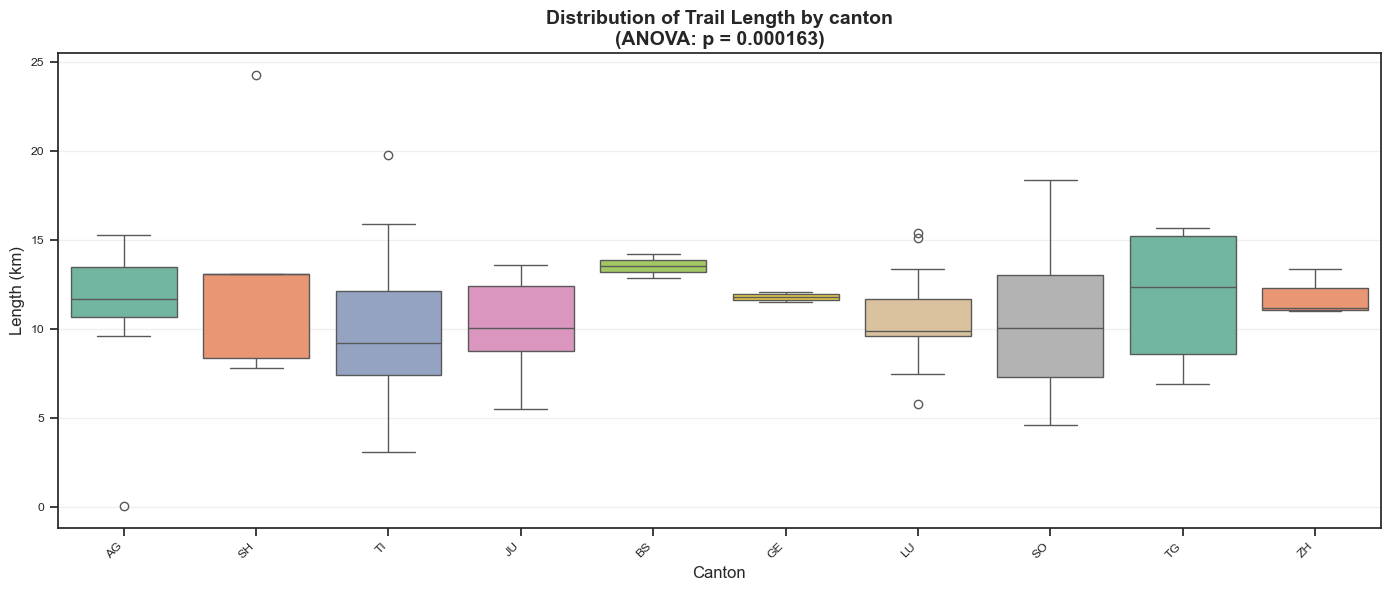

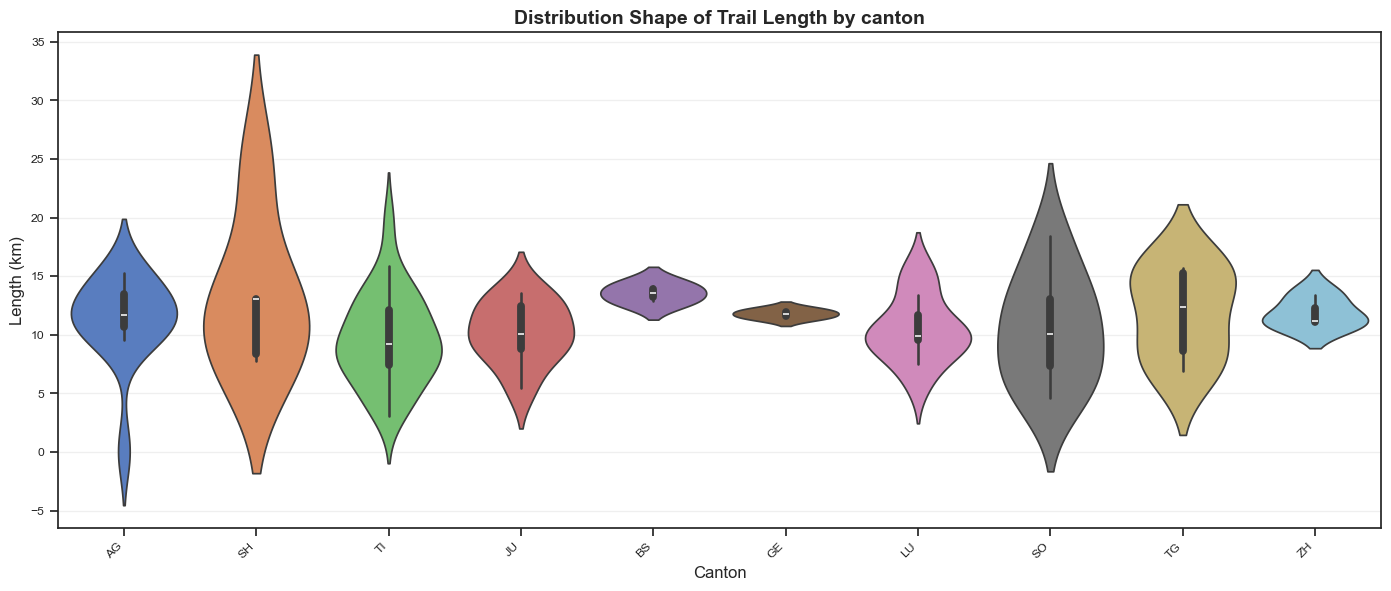

In [29]:
# Box plot to visualize differences
if group_col and 'distance_km' in df.columns:
    # Limit to top 10 groups for better readability
    top_groups = group_stats.head(10).index.tolist()
    df_plot = df_clean[df_clean[group_col].isin(top_groups)]
    
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_plot, x=group_col, y='distance_km', palette='Set2')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(group_col.capitalize(), fontsize=12)
    plt.ylabel('Length (km)', fontsize=12)
    plt.title(f'Distribution of Trail Length by {group_col}\n(ANOVA: p = {p_value:.6f})', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Additionally: Violin plot for more detailed distribution view
    plt.figure(figsize=(14, 6))
    sns.violinplot(data=df_plot, x=group_col, y='distance_km', palette='muted')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(group_col.capitalize(), fontsize=12)
    plt.ylabel('Length (km)', fontsize=12)
    plt.title(f'Distribution Shape of Trail Length by {group_col}', 
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

---
# 3. Summary of Results

## Statistical Tests - Overview

In [30]:
print("="*80)
print("SUMMARY OF STATISTICAL TESTS")
print("="*80)

print("\nCORRELATION ANALYSIS (Pearson)")
print("-" * 80)
if len(results_df) > 0:
    print(f"   Number of significant correlations (p < 0.05): {len(results_df)}")
    print(f"   Strongest correlation: {results_df.iloc[0]['Variable 1']} <-> {results_df.iloc[0]['Variable 2']}")
    print(f"   Correlation coefficient: {results_df.iloc[0]['Correlation']:.4f}")
    print(f"   p-Value: {results_df.iloc[0]['p-Value']:.6f}")
else:
    print("   No significant correlations found")

print("\nANOVA (Analysis of Variance)")
print("-" * 80)
if group_col:
    print(f"   Grouping variable: {group_col}")
    print(f"   Dependent variable: distance_km")
    print(f"   F-Statistic: {f_statistic:.4f}")
    print(f"   p-Value: {p_value:.6f}")
    print(f"   Significant: {'YES' if p_value < 0.05 else 'NO'}")
else:
    print("   Test could not be performed")

print("\n" + "="*80)
print("\nIMPORTANT:")
print("   - p < 0.05: Statistically significant (effect is likely real)")
print("   - p >= 0.05: Not significant (effect could be random)")
print("   - A low p-value does not automatically mean an important effect!")
print("="*80)

SUMMARY OF STATISTICAL TESTS

CORRELATION ANALYSIS (Pearson)
--------------------------------------------------------------------------------
   Number of significant correlations (p < 0.05): 7
   Strongest correlation: distance_km <-> duration_min
   Correlation coefficient: 0.7828
   p-Value: 0.000000

ANOVA (Analysis of Variance)
--------------------------------------------------------------------------------
   Grouping variable: canton
   Dependent variable: distance_km
   F-Statistic: 2.5014
   p-Value: 0.000163
   Significant: YES


IMPORTANT:
   - p < 0.05: Statistically significant (effect is likely real)
   - p >= 0.05: Not significant (effect could be random)
   - A low p-value does not automatically mean an important effect!
